In [3]:
pip install pycocotools

  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 7.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np                                    # Importa Numpy
import skimage.io as io                               # Importa il modulo Input/ouput di SK-Image
from skimage.transform import resize                  # Importa il modulo resize da SK-Image
from os import listdir                                # Importa il modulo listdir da OS

import json                                           # Importa Json
from matplotlib.collections import PatchCollection    # Importa PatchCollection dal modulo collections di MatPlotLib
from pycocotools.coco import COCO                     # Importa COCO dal modulo coco di PyCoco-Tools
import pycocotools.mask as cocomask                   # Importa il modulo Mask di PyCoco-Tools
import matplotlib.pyplot as plt                       # Importa il modulo  pyplot di MatPlotLib

from PIL import Image                                 # Importa il modulo Image da PIL

from tensorflow import keras                          # Importa il modulo Keras di TensorFlow
import os                                             # Importa os
import shutil

from tqdm import tqdm                                 # Importa il modulo tqdm da tqdm

In [10]:
# Path
path_in = '/kaggle/input/'
path_out = '/kaggle/working/'

coco_path = path_in + 'xview-dataset-team1/xview-dataset-team1/COCO_annotations.json'
images_path = path_in + 'xview-dataset-team1/xview-dataset-team1/images'
train_path = path_out + 'train'
test_path = path_out + 'test'
val_path = path_out + 'val'

train_images_path = path_in + 'xview-dataset-team1/xview-dataset-team1/YOLO_cfg/train.txt'
val_images_path = path_in + 'xview-dataset-team1/xview-dataset-team1/YOLO_cfg/val.txt'
test_images_path = path_in + 'xview-dataset-team1/xview-dataset-team1/YOLO_cfg/test.txt'

In [11]:
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def visualize_image_with_boxes(image_path, coco_annotations_path):
    # Carica il file COCO annotations JSON
    with open(coco_annotations_path, 'r') as coco_file:
        coco_data = json.load(coco_file)

    # Estrai l'id dell'immagine dal nome del file
    image_name = image_path.split("/")[-1]
    image_id = next((img['id'] for img in coco_data['images'] if img['file_name'] == image_name), None)

    # Se l'id dell'immagine è trovato, estrai i bounding box corrispondenti
    if image_id is not None:
        bounding_boxes = [bbox for bbox in coco_data['annotations'] if bbox['image_id'] == image_id]
        
        # Carica l'immagine usando PIL
        image = Image.open(image_path)

        # Inizializza ImageDraw con l'immagine
        draw = ImageDraw.Draw(image)

        # Disegna i bounding box sull'immagine
        for bbox in bounding_boxes:
            bbox_coords = eval(bbox['bbox'])  # Converti la stringa bbox in una lista di coordinate
            bbox_coords = [bbox_coords[0],bbox_coords[1],bbox_coords[0]+bbox_coords[2],bbox_coords[1]+bbox_coords[3]]
            draw.rectangle(bbox_coords, outline='red', width=2)

        # Visualizza l'immagine con i bounding box
        plt.imshow(image)
        plt.show()
    else:
        print(f"Image {image_name} not found in COCO annotations.")

# SPLIT TRAIN - VALIDATION - TEST

In [12]:
with open(train_images_path, 'r') as file:
    train_img_list = [line.strip() for line in file.readlines()]
    
with open(val_images_path, 'r') as file:
    val_img_list = [line.strip() for line in file.readlines()]
    
with open(test_images_path, 'r') as file:
    test_img_list = [line.strip() for line in file.readlines()]

# Crea le cartelle per i set di addestramento e test
os.makedirs(path_out + 'train', exist_ok=True)
os.makedirs(path_out + 'val', exist_ok=True)
os.makedirs(path_out + 'test', exist_ok=True) 

In [13]:
# Copia le immagini e i file di annotazione nei rispettivi set
for img_path in tqdm(train_img_list):
    shutil.copy(img_path, train_path)
    
train_len = len(os.listdir(train_path))
print(f"Il training set è composto da {train_len} immagini.")
    
for img_path in tqdm(val_img_list):
    shutil.copy(img_path, val_path)    

val_len = len(os.listdir(val_path))
print(f"Il validation set è composto da {val_len} immagini.")    

for img_path in tqdm(test_img_list):
    shutil.copy(img_path, test_path)
    
test_len = len(os.listdir(test_path))
print(f"Il test set è composto da {test_len} immagini.")

100%|██████████| 17741/17741 [01:18<00:00, 225.10it/s]


Il training set è composto da 17741 immagini.


100%|██████████| 2209/2209 [00:09<00:00, 226.91it/s]


Il validation set è composto da 2209 immagini.


100%|██████████| 86/86 [00:01<00:00, 72.59it/s]

Il test set è composto da 86 immagini.


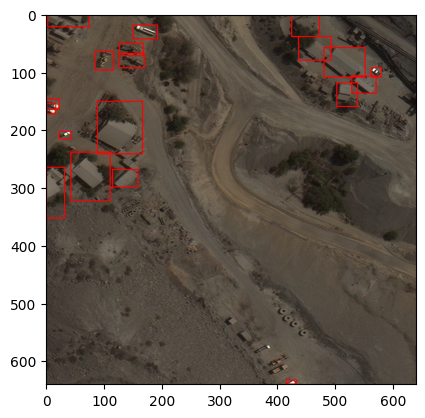

In [16]:
# Stampa di prova di un'immmagine di training con bounding box
visualize_image_with_boxes(train_path + '/' + os.listdir(train_path)[1], coco_path)

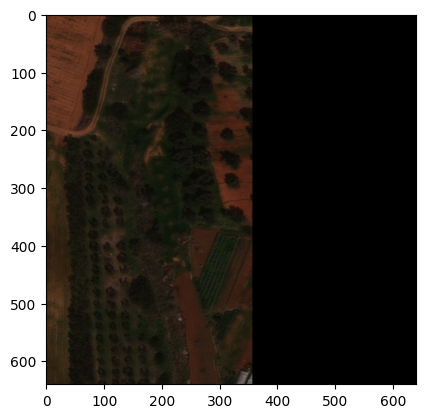

In [17]:
# Stampa di prova di un'immmagine di validation con bounding box
visualize_image_with_boxes(val_path + '/' + os.listdir(val_path)[1], coco_path)

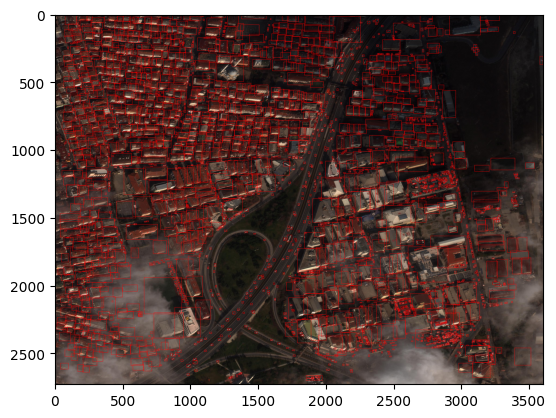

In [18]:
# Stampa di prova di un'immmagine di test con bounding box
visualize_image_with_boxes(test_path + '/' + os.listdir(test_path)[1], coco_path)

### DOWNLOAD DATASET SPLITTATO

In [19]:
import zipfile
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

zip_dir('/kaggle/working/')

/kaggle/working/directory.zip